## Informations about the CSP algorithm: [here](./README.md)

In [81]:
import mne
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
import matplotlib.pyplot as plt
import glob


from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, ShuffleSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from mne.decoding import CSP
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from mne.decoding import (
    SlidingEstimator,
    GeneralizingEstimator,
    Scaler,
    cross_val_multiscore,
    LinearModel,
    get_coef,
    Vectorizer,
    CSP,
)
import numpy as np
from mne.preprocessing import ICA

from lightgbm import LGBMClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

In [91]:

'''
https://github.com/mne-tools/mne-python/blob/main/mne/datasets/eegbci/eegbci.py#L110
=========  ===================================
run        task
=========  ===================================
1          Baseline, eyes open
2          Baseline, eyes closed
3, 7, 11   Motor execution: left vs right hand
4, 8, 12   Motor imagery: left vs right hand
5, 9, 13   Motor execution: hands vs feet
6, 10, 14  Motor imagery: hands vs feet
=========  ===================================
'''
raws = []
# f = [5,9,13]
f = [3, 7, 11]
for n in range(1, 2):
    files = glob.glob(f'../files/S00{n}/*.edf')
    files.sort()
    for i in f:
        print(i)
        current_file = files[i-1]
        r = read_raw_edf(current_file, preload=True, stim_channel='auto')
        events, _ = mne.events_from_annotations(r)
        if i in [5, 9, 13]:
            new_labels_events = {1:'rest', 2:'action_hand', 3:'action_feet'} # action
        elif i in [3, 7, 11]:
            new_labels_events = {1:'rest', 2:'left_hand', 3:'right_hand'} # imagine
        else:
            new_labels_events = {1:'rest', 2:'imagine_hand', 3:'imagine_feet'} # imagine
        new_annot = mne.annotations_from_events(events=events, event_desc=new_labels_events, sfreq=r.info['sfreq'], orig_time=r.info['meas_date'])
        r.set_annotations(new_annot)
        raws.append(r)
        
raw_obj = concatenate_raws(raws)

3
Extracting EDF parameters from /Users/owalid/42/post_intership/total-perspective-vortex/files/S001/S001R01.edf...
EDF file detected


Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9759  =      0.000 ...    60.994 secs...
Used Annotations descriptions: ['T0']
7
Extracting EDF parameters from /Users/owalid/42/post_intership/total-perspective-vortex/files/S001/S001R07.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']
11
Extracting EDF parameters from /Users/owalid/42/post_intership/total-perspective-vortex/files/S001/S001R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T0', 'T1', 'T2']


Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1057 samples (6.606 sec)

Filtering raw data in 3 contiguous segments


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.2s finished


Setting up band-pass filter from 8 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 265 samples (1.656 sec)

Used Annotations descriptions: ['left_hand', 'rest', 'right_hand']
<Info | 7 non-empty values
 bads: []
 ch_names: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 8.0 Hz
 lowpass: 40.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
>
{'left_hand': 1, 'rest': 2, 'right_hand': 3}


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 10 components
Fitting ICA took 0.8s.


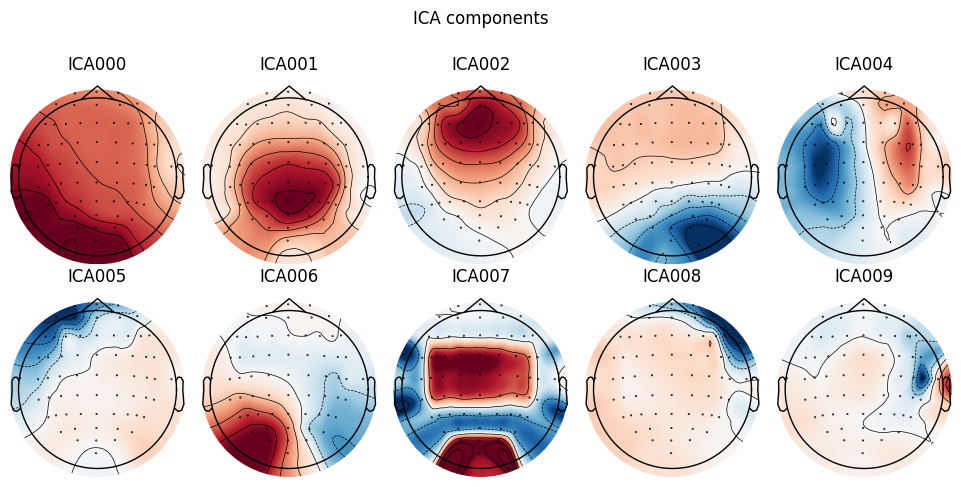

Using EOG channel: Fpz
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 1600 samples (10.000 sec)

... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Used Annotations descriptions: ['left_hand', 'right_hand']
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]


/Users/owalid/.pyenv/versions/3.8.12/lib/python3.8/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


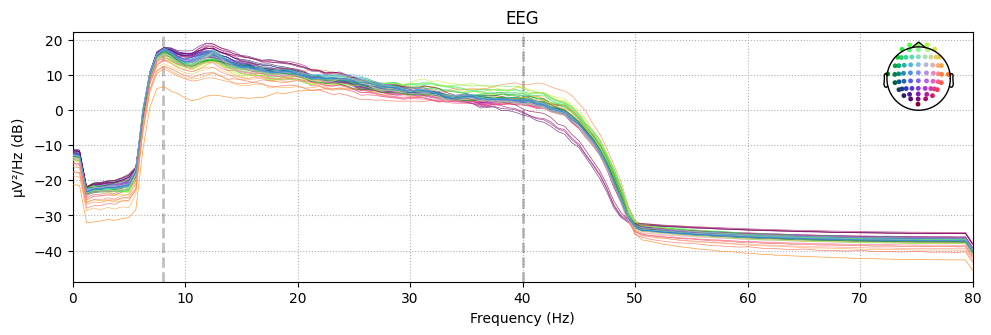

In [92]:
original_raw = raw_obj.copy()

# filters
notch_freq = 60
original_raw.notch_filter(notch_freq, fir_design='firwin')

low_cutoff = 8
high_cutoff = 40
original_raw.filter(low_cutoff, high_cutoff, fir_design='firwin')

events, event_dict = mne.events_from_annotations(original_raw)
print(original_raw.info)
print(event_dict)
picks = mne.pick_types(original_raw.info, meg=True, eeg=True, stim=False, eog=False, exclude='bads')
eegbci.standardize(original_raw)
montage = mne.channels.make_standard_montage('standard_1005')
original_raw.set_montage(montage)

## ICA
n_components = 10
ica = ICA(n_components=n_components, random_state=97, max_iter=800)
ica.fit(original_raw)
ica.plot_components()
components_to_excludes, scores = ica.find_bads_eog(original_raw, ch_name='Fpz')
if components_to_excludes is not None and len(components_to_excludes) > 0:
    ica.plot_properties(original_raw, picks=components_to_excludes)
else:
    print("No components to exclude")
original_raw.compute_psd().plot()

event_id = {'left_hand': 1, 'right_hand': 2}
events, event_dict = mne.events_from_annotations(original_raw, event_id=event_id)
print(picks)

In [93]:
tmin = -0.5  # Time before event in seconds
tmax = 4.  # Time after event in seconds
epochs = mne.Epochs(original_raw, events, event_dict, tmin, tmax, proj=True, picks=picks, baseline=None, preload=True)
print(epochs)
print(epochs.events[:, -1] - 1)

Not setting metadata
30 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 30 events and 721 original time points ...
0 bad epochs dropped
<Epochs |  30 events (all good), -0.5 - 4 sec, baseline off, ~10.7 MB, data loaded,
 'left_hand': 15
 'right_hand': 15>
[0 1 0 1 0 1 1 0 0 1 1 0 1 0 0 1 0 1 0 0 1 1 0 0 1 1 0 1 0 1]


In [94]:
X = epochs.get_data()
y = epochs.events[:, -1]
print(X.shape)
print(y.shape)

(30, 64, 721)
(30,)


In [95]:
y

array([1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2,
       1, 1, 2, 2, 1, 2, 1, 2])

Computing rank from data with rank=None
    Using tolerance 0.00019 (2.2e-16 eps * 64 dim * 1.3e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00019 (2.2e-16 eps * 64 dim * 1.3e+10  max singular value)
    Estimated rank (mag): 64
    MAG: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating covariance using EMPIRICAL
Done.
(30, 64, 721)
(30, 2)
(15, 721)


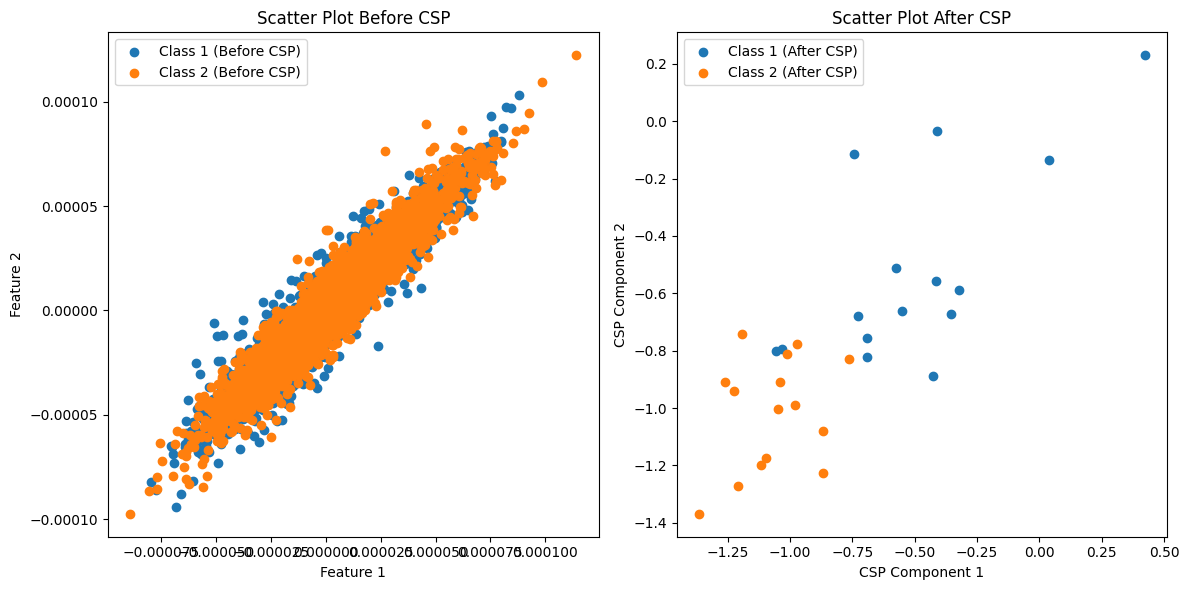

In [103]:
n_components = 2

# Create the CSP object
csp = CSP(n_components=n_components, reg=None, log=True)


X_csp = csp.fit_transform(X, y)


# Separate the data by class labels
class_1_data = X[y == 1]
class_2_data = X[y == 2]
class_1_data_csp = X_csp[y == 1]
class_2_data_csp = X_csp[y == 2]

print(X.shape)
print(X_csp.shape)

print(class_1_data[:, 0].shape)
# print(class_2_data.shape)
# print(class_1_data_csp.shape)
# print(class_2_data_csp.shape)

# Plot scatter plots comparing both classes before and after CSP transformation
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(class_1_data[:, 0], class_1_data[:, 1], label='Class 1 (Before CSP)')
plt.scatter(class_2_data[:, 0], class_2_data[:, 1], label='Class 2 (Before CSP)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Scatter Plot Before CSP')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(class_1_data_csp[:, 0], class_1_data_csp[:, 1], label='Class 1 (After CSP)')
plt.scatter(class_2_data_csp[:, 0], class_2_data_csp[:, 1], label='Class 2 (After CSP)')
plt.xlabel('CSP Component 1')
plt.ylabel('CSP Component 2')
plt.title('Scatter Plot After CSP')
plt.legend()

plt.tight_layout()
plt.show()

In [79]:
def my_csp(X, y, n_components):
    class1_data = X[y == 1]
    class2_data = X[y == 2]

    class1_data_reshaped = class1_data.reshape(-1, class1_data.shape[-1])
    class2_data_reshaped = class2_data.reshape(-1, class2_data.shape[-1])
    # Calculate covariance matrices for each class
    cov1 = np.cov(class1_data_reshaped, rowvar=False)
    cov2 = np.cov(class2_data_reshaped, rowvar=False)

    # Compute whitening transformation matrices
    _, _, W1 = np.linalg.svd(cov1)
    _, _, W2 = np.linalg.svd(cov2)

    P = np.dot(W1.T, W2)

    # Perform eigenvalue decomposition on the CSP transformation matrix
    _, _, V = np.linalg.svd(P)

    # Select the top num_filters CSP filters
    csp_filters_ = V[:n_components]

    transformed_data = np.dot(X, csp_filters_.T)
    transformed_data = np.log(np.var(transformed_data, axis=2))
    
    return X_csp

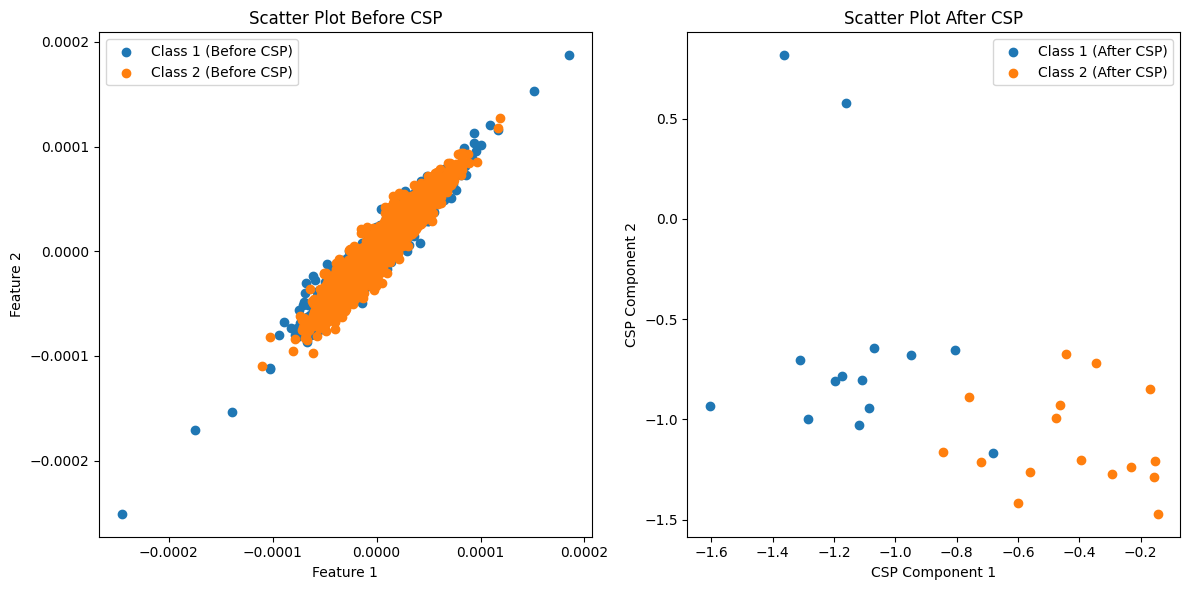

In [84]:
n_components = 5

# # Create the CSP object
# csp = CSP(n_components=n_components, reg=None, log=True)


X_csp = my_csp(X, y, 2)


# Separate the data by class labels
class_1_data = X[y == 1]
class_2_data = X[y == 2]
class_1_data_csp = X_csp[y == 1]
class_2_data_csp = X_csp[y == 2]

# Plot scatter plots comparing both classes before and after CSP transformation
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(class_1_data[:, 0], class_1_data[:, 1], label='Class 1 (Before CSP)')
plt.scatter(class_2_data[:, 0], class_2_data[:, 1], label='Class 2 (Before CSP)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Scatter Plot Before CSP')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(class_1_data_csp[:, 0], class_1_data_csp[:, 1], label='Class 1 (After CSP)')
plt.scatter(class_2_data_csp[:, 0], class_2_data_csp[:, 1], label='Class 2 (After CSP)')
plt.xlabel('CSP Component 1')
plt.ylabel('CSP Component 2')
plt.title('Scatter Plot After CSP')
plt.legend()

plt.tight_layout()
plt.show()